In [17]:
from utils import TickerDataGenerator
from os import listdir
from random import sample
from typing import *
import sys
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import torch
import torch.nn as nn

In [3]:
def _is_colab() -> bool:
    return 'google.colab' in sys.modules

def mount_drive():
    if _is_colab():
        from google.colab import drive
        drive.mount("/content/gdrive")

def choose_tickers(PATH: str, num_tickers: int) -> List:
    files = listdir(PATH)
    return [x.replace(".csv", "") for x in sample(files, num_tickers)]

def fit_scaler(scaler: MinMaxScaler, 
               X_train: np.ndarray, 
               y_train: np.ndarray, 
               X_test: list, 
               y_test: list):
    #we want the scaler to handle all sorts of price action, high volatility to low...so fit all together
    data_to_scale = np.concatenate([X_train.flatten(), 
                                    y_train.flatten(), 
                                    np.array(X_test).flatten(), 
                                    np.array(y_test).flatten()]).reshape(-1,1)
    scaler.fit(data_to_scale)

In [4]:
mount_drive()

Mounted at /content/gdrive


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
PATH = "gdrive/MyDrive/PriceData/PriceData"
TICKER_LIST = choose_tickers(PATH, 20)
FEATURES = ["close", "high", "low"]
LABEL = "close"
SPLIT_PERC = 0.2
PERIOD = 20

data_gen = TickerDataGenerator(TICKER_LIST, PATH)

X_train, y_train, X_test, y_test = data_gen.create_train_data(feature_cols = FEATURES, 
                                                              label_col = LABEL,
                                                              split_perc=SPLIT_PERC,
                                                              period=PERIOD,
                                                              as_pct_change=True, 
                                                              as_cumsum=True)
print(f"""
Num Train samples: {X_train.shape[0]}
Num Test samples: {sum([x.shape[0] for x in X_test])}
""")



Num Train samples: 16280
Num Test samples: 4060



In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
fit_scaler(scaler, X_train, y_train, X_test, y_test)

X_train = np.array([scaler.transform(x) for x in X_train])
y_train = np.array([scaler.transform(y.reshape(-1,1)) for y in y_train])
X_test =  [np.array([scaler.transform(x) for x in ticker]) for ticker in X_test]

In [12]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = [torch.from_numpy(x).type(torch.Tensor) for x in X_test]
y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1,1)

In [21]:
INPUT_DIM = X_train.size(-1)
NUM_LAYERS = 3
OUTPUT_DIM = y_train.size(-1)
NUM_EPOCHS = 60

In [26]:
class PricePredictionLSTM(nn.Module):
    def __init__(self, input_dim, num_layers, output_dim):
        super(PricePredictionLSTM, self).__init__()
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.LSTM = nn.LSTM(input_dim, 32, num_layers, batch_first=True)
        self.dense1 = nn.Linear(32, 16)
        self.dense2 = nn.Linear(16, output_dim)

    def forward(self, X):
        hidden = torch.zeros(self.num_layers, X.size(0), 32).requires_grad_()
        c = deepcopy(hidden)
        out, _ = self.LSTM(X, (hidden.detach(), c.detach()))
        out = self.dense2( self.dense1(out[:, -1, :]) )
        return out

model = PricePredictionLSTM(INPUT_DIM, NUM_LAYERS, OUTPUT_DIM)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
def train_model():
    hist = np.zeros(NUM_EPOCHS)
    start_time = time.time()
    for e in range(NUM_EPOCHS):
        optimizer.zero_grad()
        yhat = model(X_train)
        loss = criterion(yhat, y_train)
        print(f"Epoch: {e} || MSE: {loss.item()}\n")
        hist[e] = loss.item()
        loss.backward()
        optimizer.step()

    print(f"Total Time Elapsed: {time.time()-start_time}")
    return hist

hist = train_model()


Epoch: 0 || MSE: 0.0654447004199028

Epoch: 1 || MSE: 0.03544935956597328

Epoch: 2 || MSE: 0.050814516842365265

Epoch: 3 || MSE: 0.03635139763355255

Epoch: 4 || MSE: 0.03479243442416191

Epoch: 5 || MSE: 0.036320701241493225

Epoch: 6 || MSE: 0.03638531640172005

Epoch: 7 || MSE: 0.03513571619987488

Epoch: 8 || MSE: 0.03345758095383644

Epoch: 9 || MSE: 0.03162999451160431

Epoch: 10 || MSE: 0.02934415079653263

Epoch: 11 || MSE: 0.025763781741261482

Epoch: 12 || MSE: 0.019106147810816765

Epoch: 13 || MSE: 0.01040154229849577

Epoch: 14 || MSE: 0.010672313161194324

Epoch: 15 || MSE: 0.016041386872529984

Epoch: 16 || MSE: 0.0122963422909379

Epoch: 17 || MSE: 0.008253414183855057

Epoch: 18 || MSE: 0.00772594241425395

Epoch: 19 || MSE: 0.009033692069351673

Epoch: 20 || MSE: 0.009734614752233028

Epoch: 21 || MSE: 0.009209967218339443

Epoch: 22 || MSE: 0.007844635285437107

Epoch: 23 || MSE: 0.006169603206217289

Epoch: 24 || MSE: 0.0047256299294531345

Epoch: 25 || MSE: 0.004

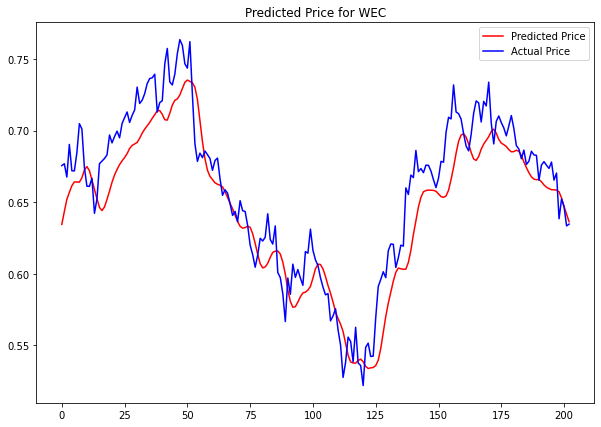

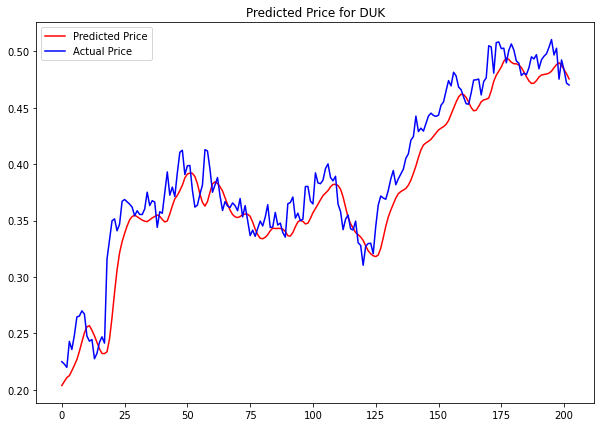

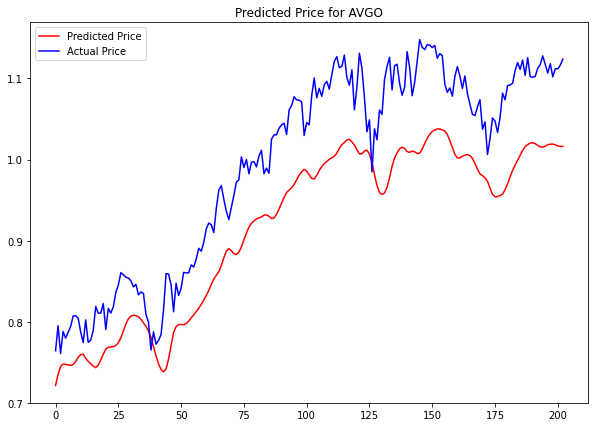

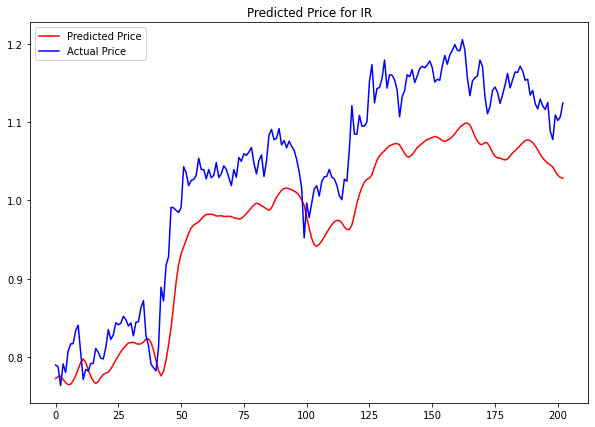

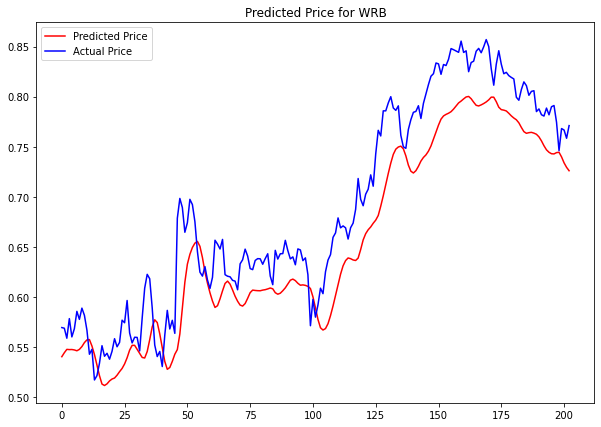

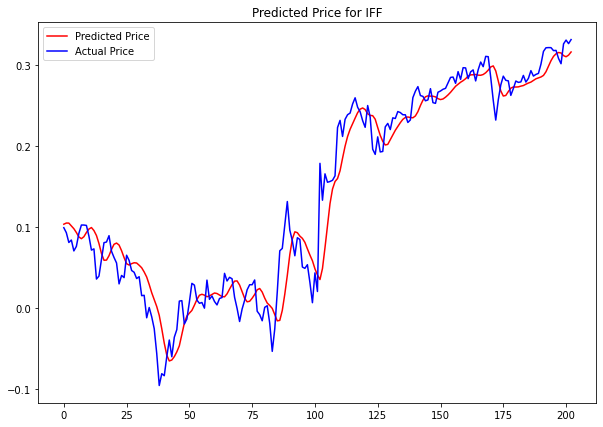

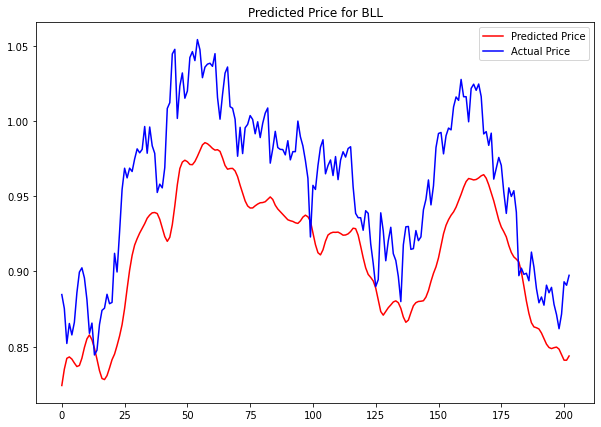

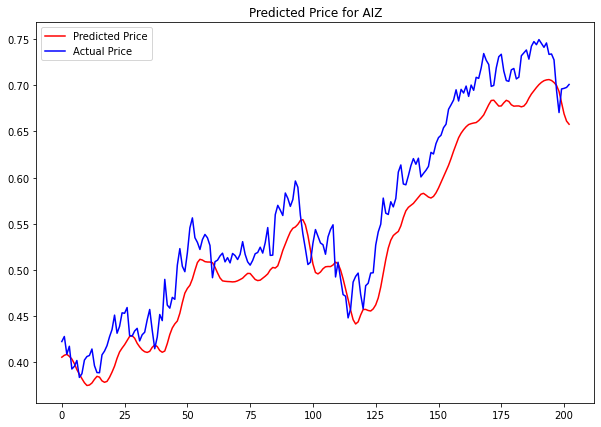

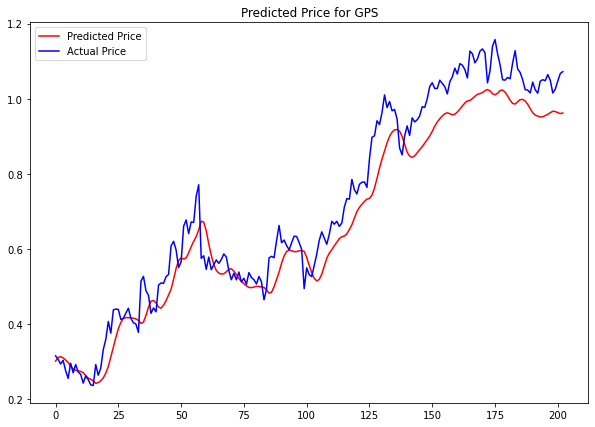

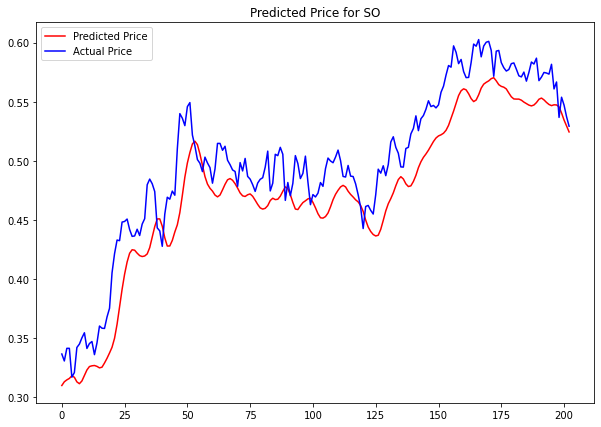

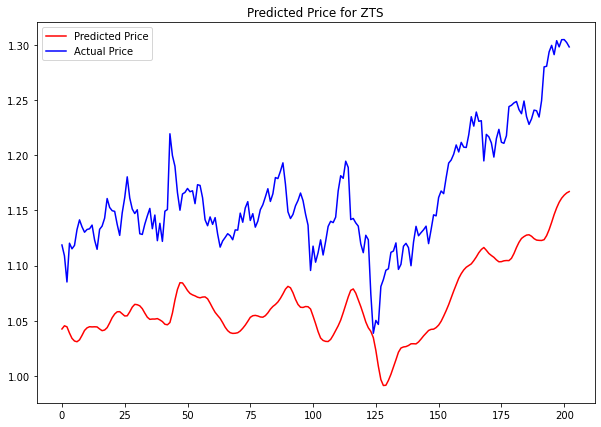

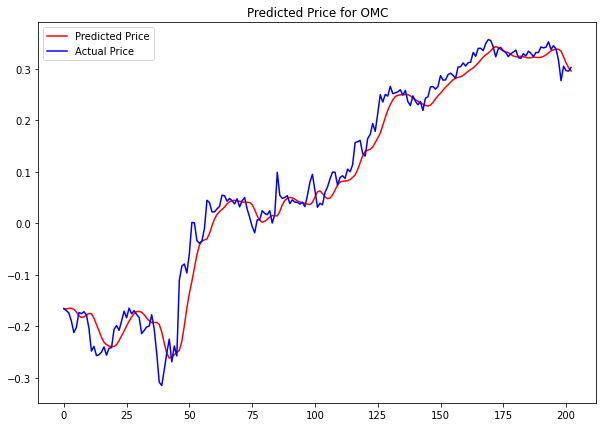

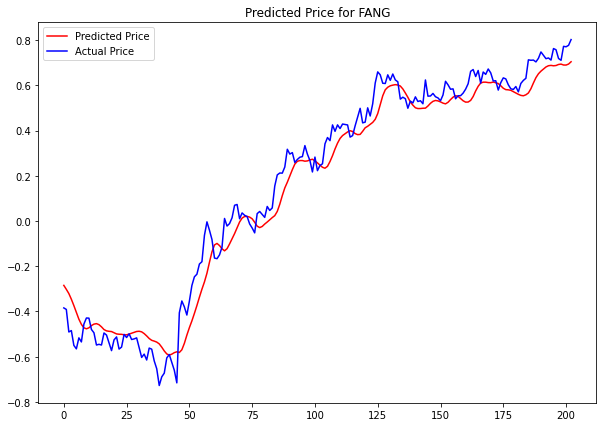

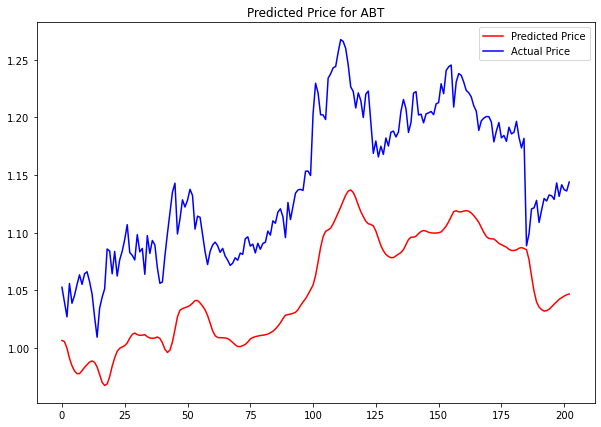

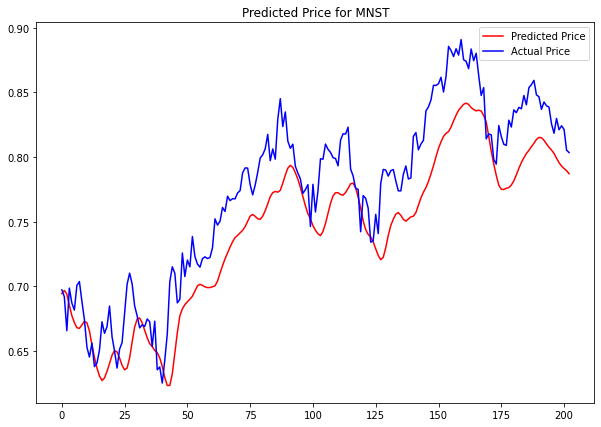

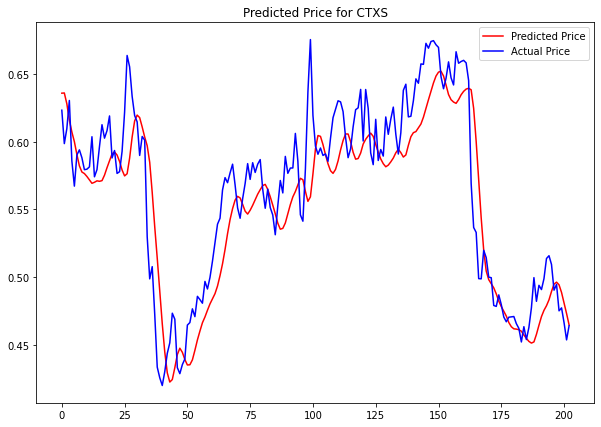

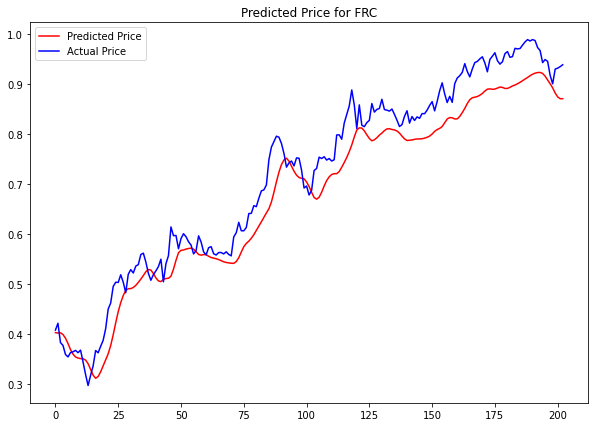

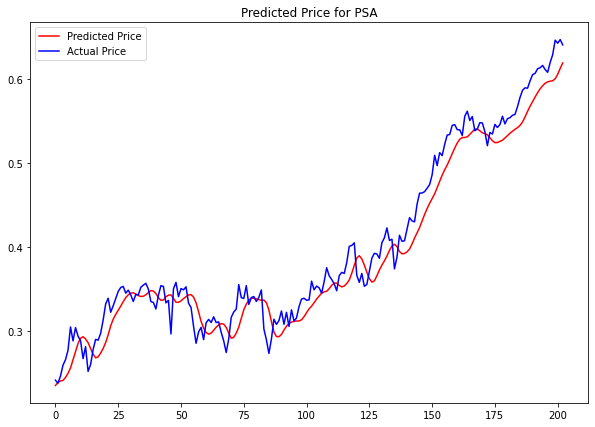

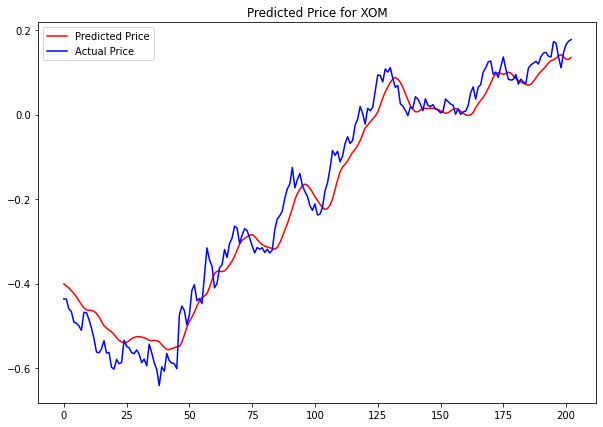

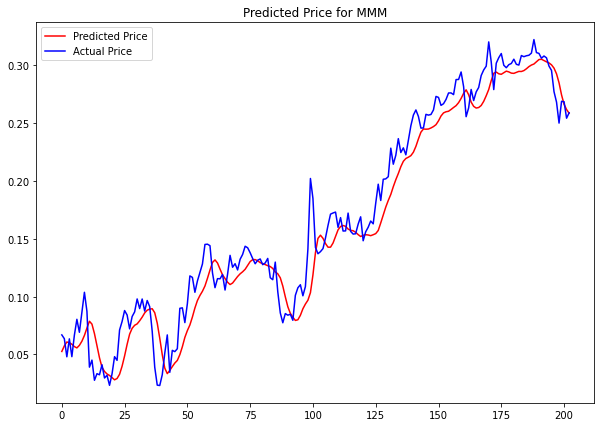

In [28]:
for idx in range(len(TICKER_LIST)):
    ticker = TICKER_LIST[idx]

    ticker_test = X_test[idx]

    ticker_yhat = model(ticker_test)
    ticker_yhat = scaler.inverse_transform(ticker_yhat.detach())
    ticker_y = y_test[idx]

    #Plot Predicted vs Acutal
    plt.figure(figsize=(10,7))
    plt.plot(ticker_yhat, c="red", label="Predicted Price")
    plt.plot(ticker_y, c="blue", label="Actual Price")
    plt.legend()
    plt.title(f"Predicted Price for {ticker}")
    plt.show()
